The purpose of this notebook is to evaluate GPDs $G_q(x,\eta,t)$ as well as their conformal moments $\mathbb{G}_q(n,\eta,t)$, where, for a generic GPD, we have its conformal moment expansion
\begin{equation}
G_q(x,\eta,t)=\sum_{n=0}^\infty (-1)^{n}p_n(x,\eta)\mathbb{F}_q(n,\eta,t),\qquad G_g(x,\eta,t)=\sum_{n=1}^\infty (-1)^{n-1}\, {^g\!p}_n(x,\eta) \mathbb{G}_g(n,\eta,t),
\end{equation}
where $G=H,E,\widetilde{H},\widetilde{E},H^T,E^T,\widetilde{H}^T,\widetilde{E}^T$.

To this end, we import the MSTW PDF parametrization of PDFs. The conformal moments are obtained by Reggeized $x$ integrals over PDFs at some input scale $\mu_0=1$ GeV and evolved using the pertinent RGEs.

In [1]:
# Import necessary libraries and set display options
import numpy as np
# import mpmath as mp
# import matplotlib.pyplot as plt
# from scipy.integrate import quad, trapezoid
# from joblib import Parallel, delayed
# from scipy.special import gamma, digamma

# import time
# import re
# import os

from mstw_pdf import (
    plot_uv_minus_dv_PDF, 
    plot_uv_plus_dv_plus_S_PDF,
    plot_gluon_PDF
)

from stringy_gpds import (
    plot_moments, 
    plot_fourier_transform_moments,
    plot_moments_D,
    evolve_conformal_moment,
    evolve_singlet_D,
    plot_mellin_barnes_gpd_integrand,  
    plot_non_singlet_quark_gpd, 
    plot_singlet_quark_gpd,
    plot_gluon_gpd
)
# Set display options
np.set_printoptions(linewidth=200)

Plots of conformal moments $\mathbb{G}_q(n,\eta,t)$ and their RGE evolution

Momentum space

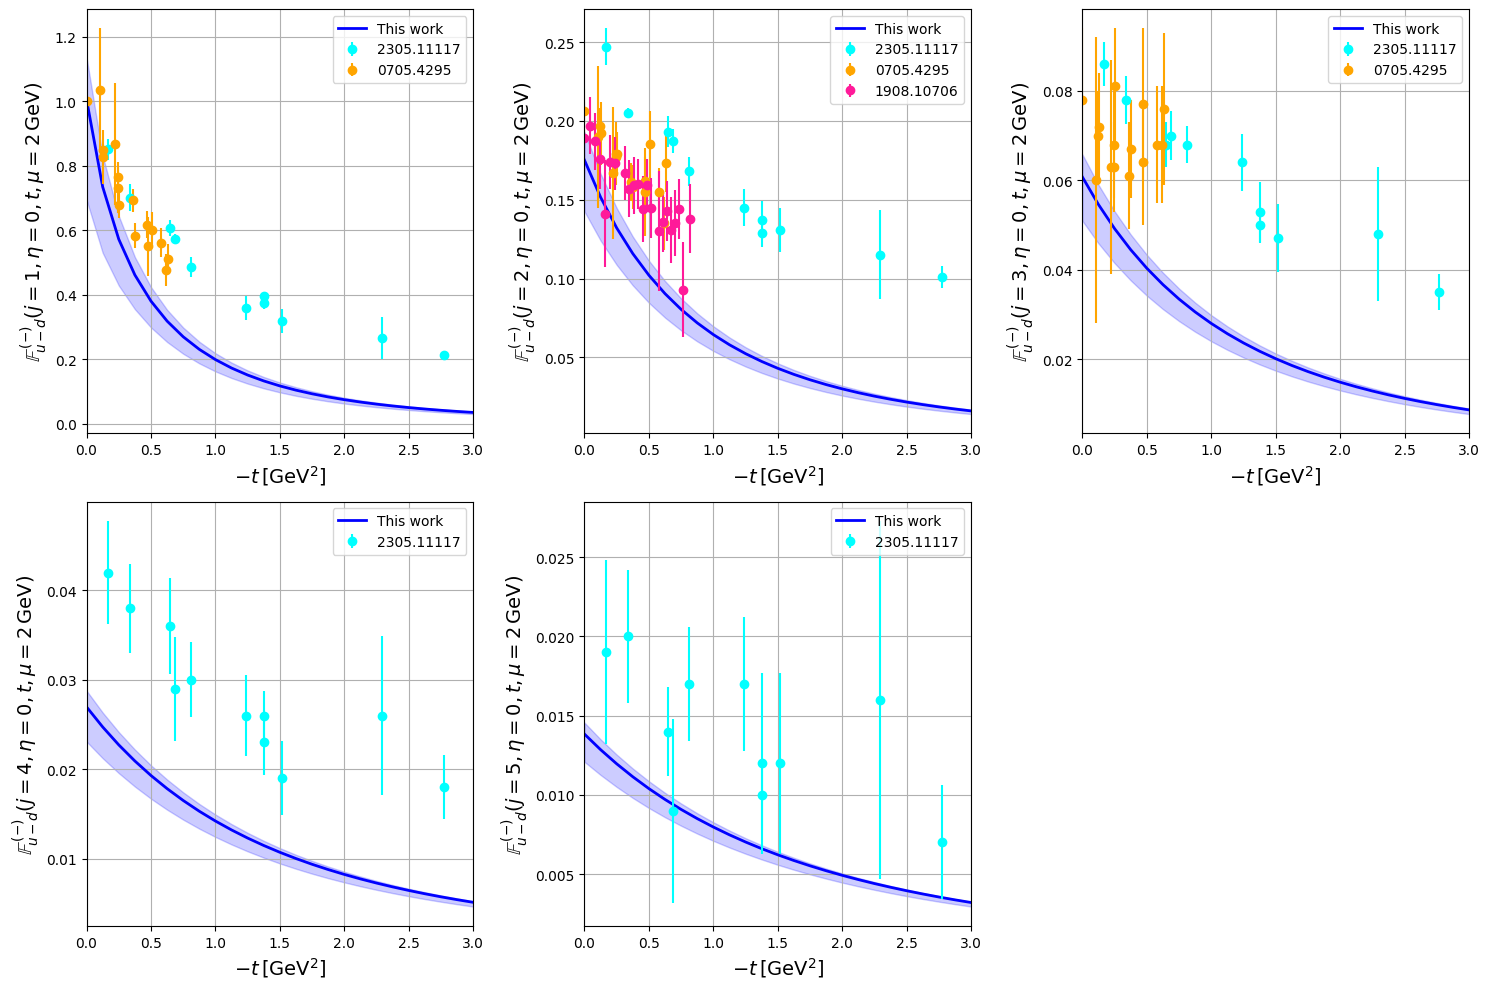

In [2]:
#NonSingletIsovector
y_label = "$\\mathbb{{F}}_{{u-d}}^{{\,\,(-)}}$"
moment_type = "NonSingletIsovector"
moment_label = "A"

plot_moments(0,y_label,3,"quark",moment_type, moment_label,25)

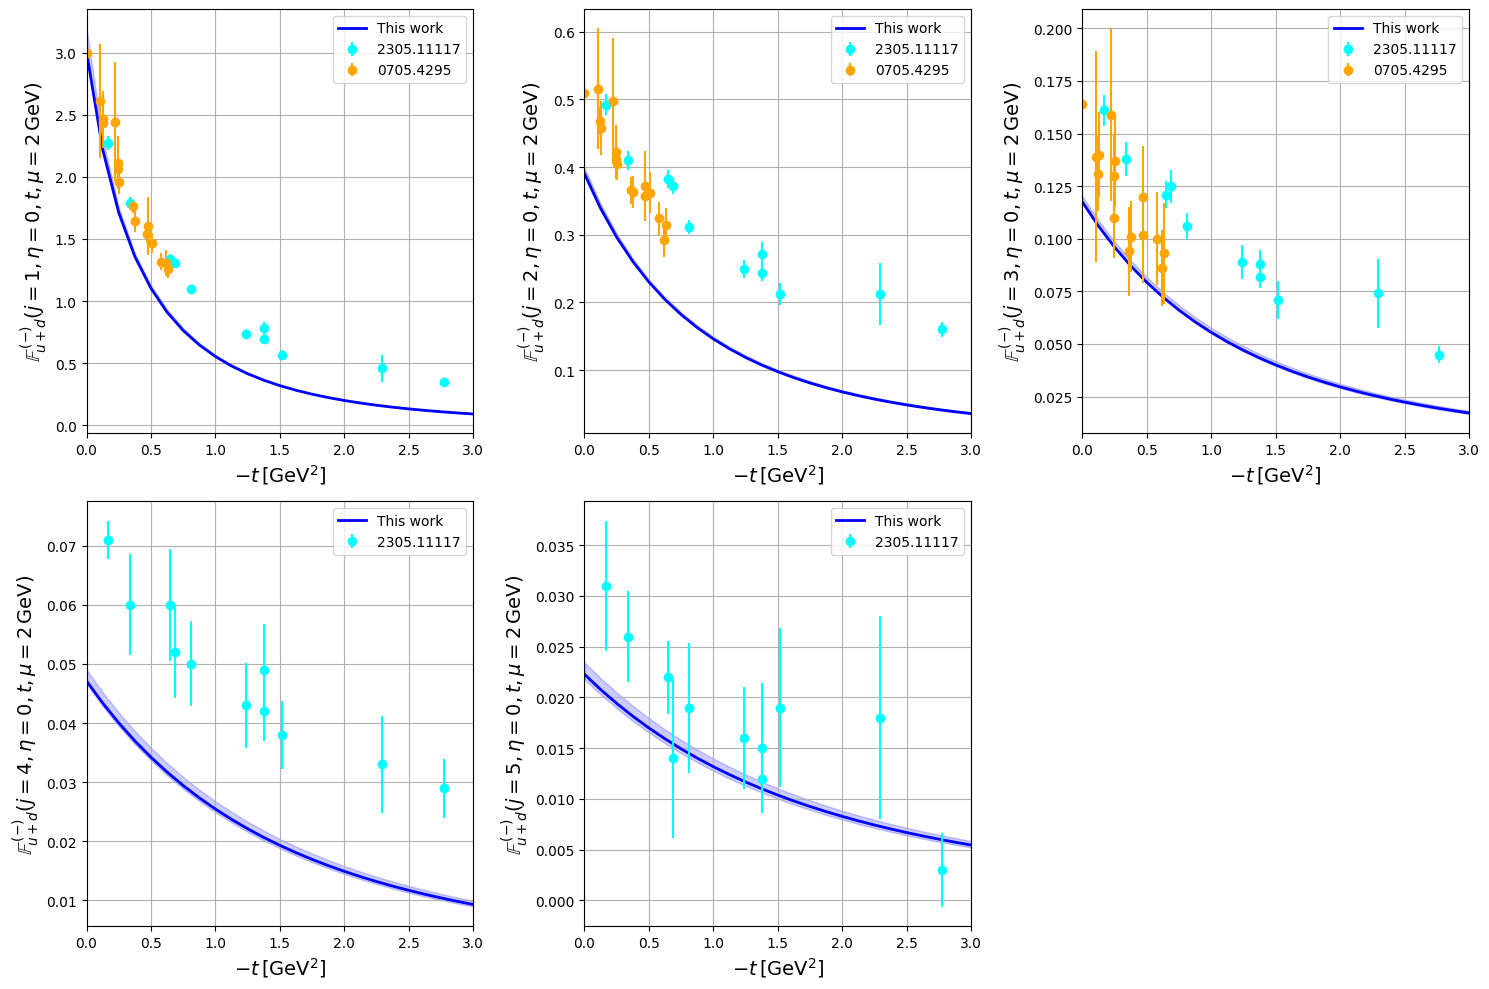

In [3]:
# NonSingletIsoscalar
y_label = "$\\mathbb{{F}}_{{u+d}}^{{\,\,(-)}}$"
moment_type = "NonSingletIsoscalar"
moment_label = "A"

plot_moments(0,y_label,3,"quark",moment_type, moment_label,25)

Impact parameter representation

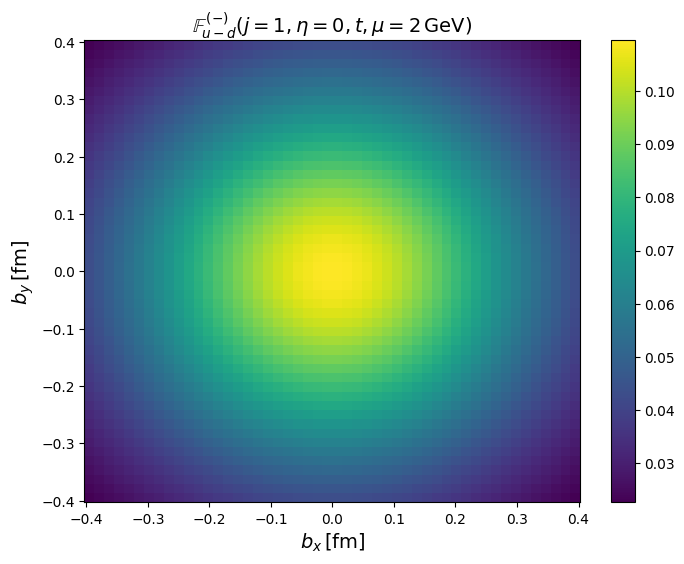

In [4]:
# Plot NonSingletIsovector in 2D impact parameter space
moment_type = "NonSingletIsovector"
moment_label = "A"
plot_title = "$\\mathbb{{F}}_{{u-d}}^{{\,\,(-)}}$"
plot_fourier_transform_moments(1,0,2,plot_title,moment_type=moment_type,moment_label=moment_label)

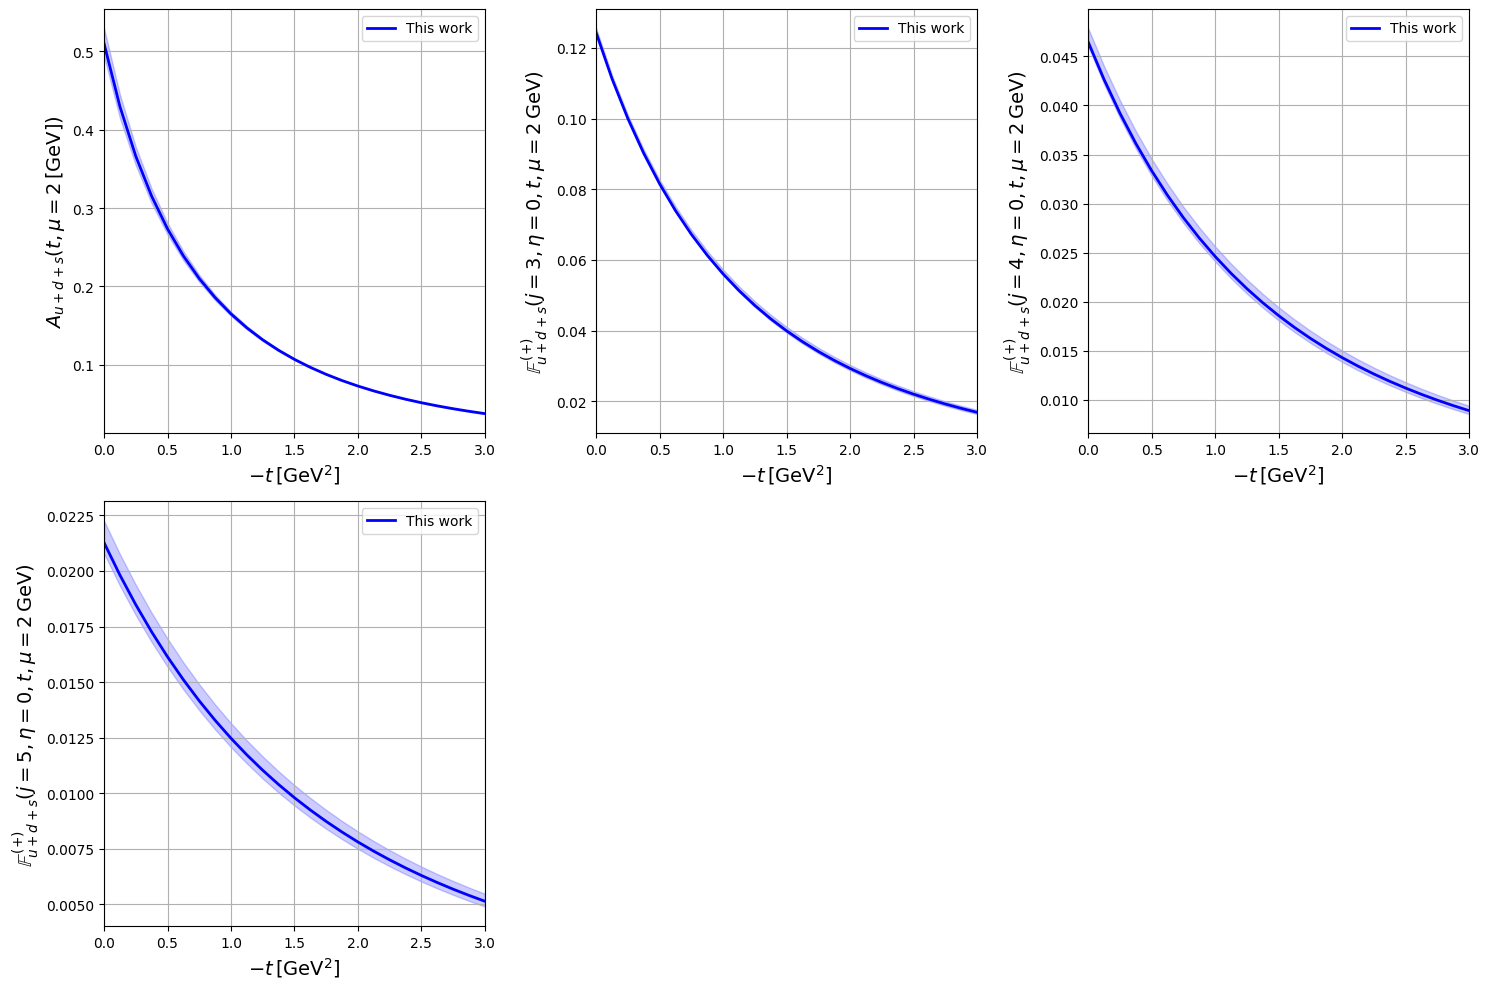

In [5]:
# Sea Quark Singlet
y_label = "$\\mathbb{{F}}_{{u+d+s}}^{{\,\,(+)}}$"
moment_type = "Singlet"
moment_label = "A"

plot_moments(0,y_label,3,"quark",moment_type, moment_label,25)

In [6]:
# 0.510024649589122
# -1.30044714988575
# 0.50111263175031
# -2.57000756593034
print(evolve_conformal_moment(2,0,-1e-4,2,3,"quark","Singlet","A","central"))
print(evolve_singlet_D(2,1,-1e-4,2,3,"quark","A","central"))
print(evolve_conformal_moment(2,0,-1e-4,2,3,"gluon","Singlet","A","central"))
print(evolve_singlet_D(2,1,-1e-4,2,3,"gluon","A","central"))

0.5100080912825354
-1.3000426341191
0.5010095423139207
-2.5700257125908


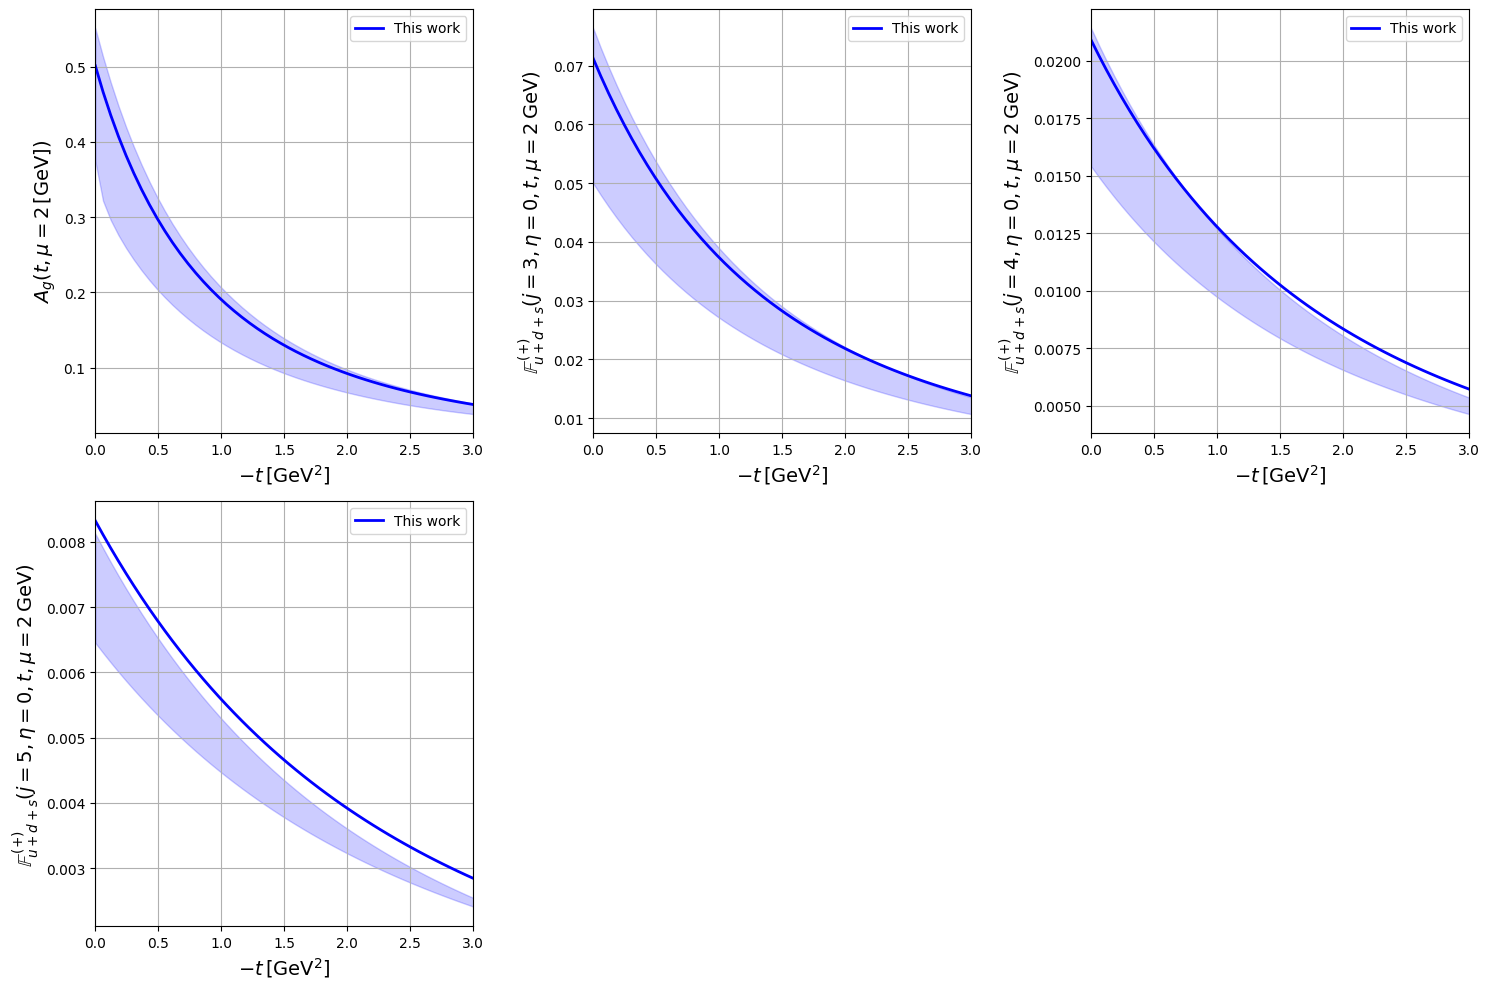

In [7]:
y_label = "$\\mathbb{{F}}_{{u+d+s}}^{{\,\,(+)}}$"
particle = "gluon"
moment_type = "Singlet"
moment_label = "A"
plot_moments(0,y_label,3,particle,moment_type,moment_label)

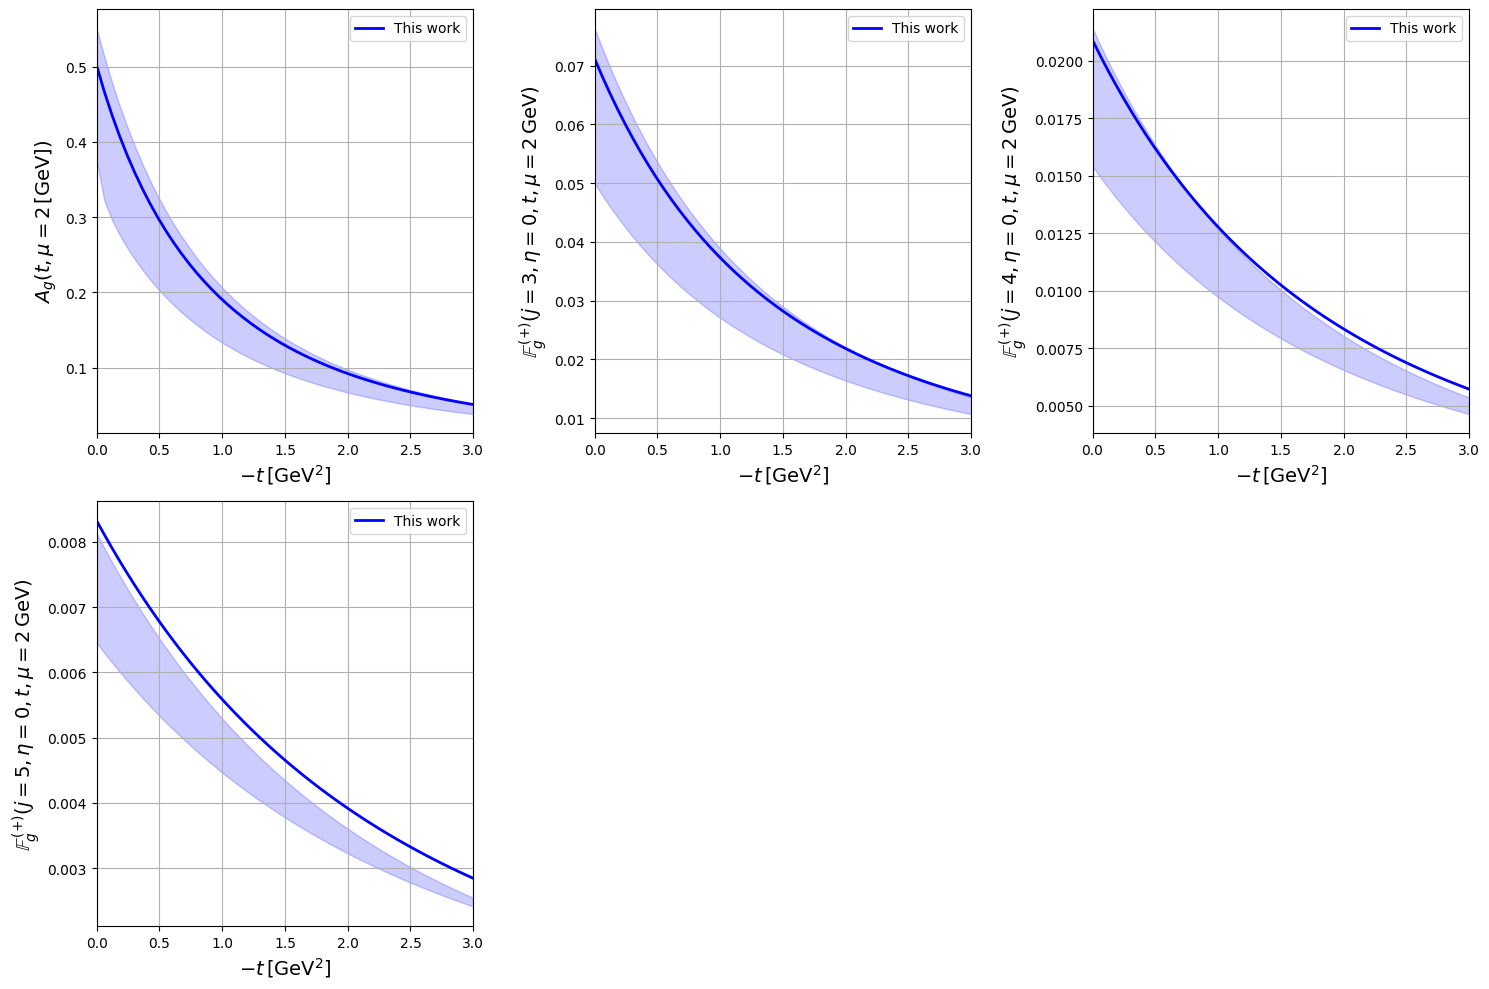

In [8]:
y_label = "$\\mathbb{{F}}_{{g}}^{{\,\,(+)}}$"
particle = "gluon"
moment_type = "Singlet"
moment_label = "A"
plot_moments(0,y_label,3,particle,moment_type,moment_label)

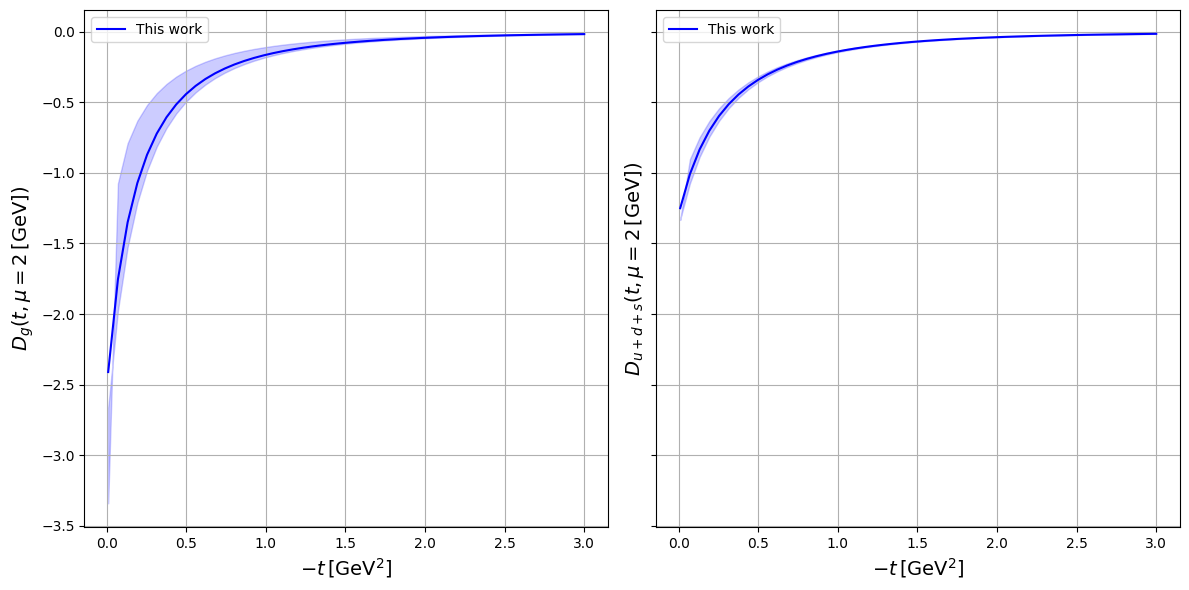

In [9]:
plot_moments_D(3,2)

Plots of GPDs through Mellin-Barnes Integral

Integrand at j_max=100
0.00150229021622644
0.000331708634636586


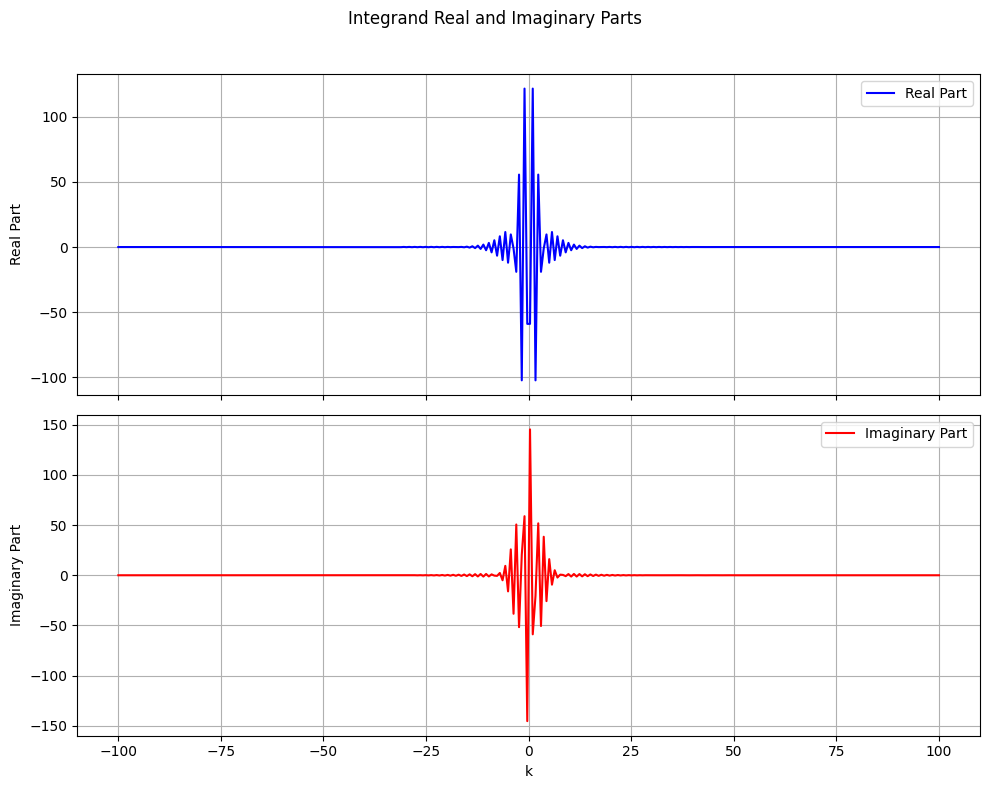

In [10]:
plot_mellin_barnes_gpd_integrand(x=1e-2, eta=1e-4, t=-0.1, mu=1.0, j_max=100,particle="gluon",moment_type="Singlet")

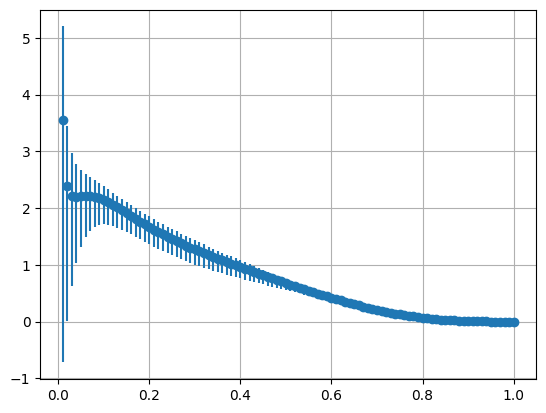

In [11]:
plot_uv_minus_dv_PDF()

Time for initial sampling: 2.156034 seconds
Time for plot computation: 11.105392 seconds


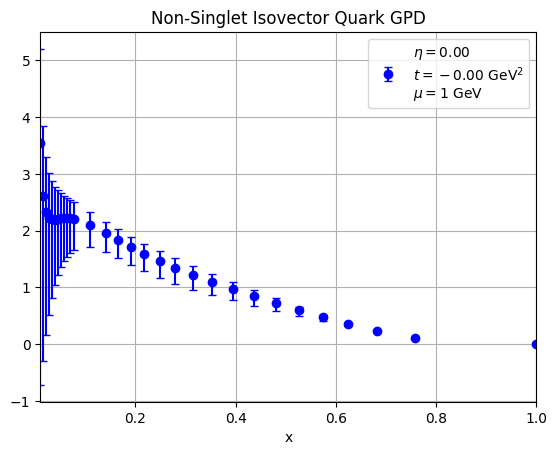

In [ ]:
plot_non_singlet_quark_gpd(0,-1e-4,1,x_0=1e-2)

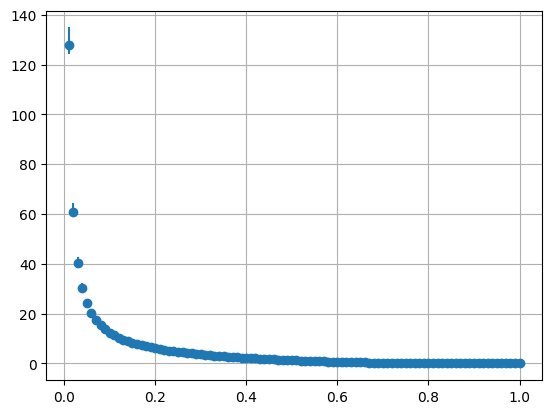

In [13]:
plot_uv_plus_dv_plus_S_PDF()

Time for plot computation: 74.574857 seconds


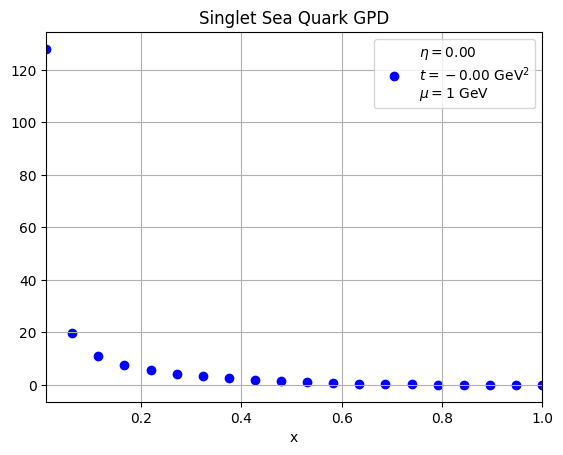

In [ ]:
plot_singlet_quark_gpd(0,-1e-4,1,x_0=1e-2,sampling=False,error_bars=False,n_points=20)

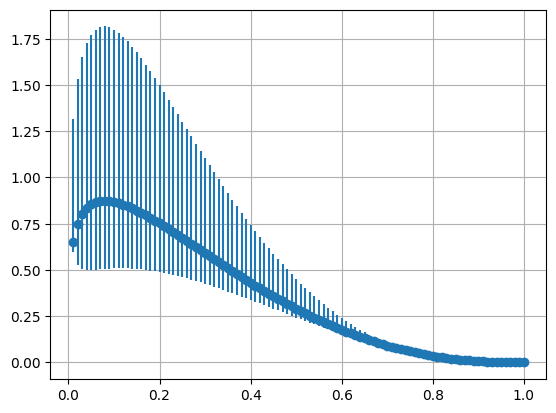

In [15]:
plot_gluon_PDF()

Time for plot computation: 181.173960 seconds


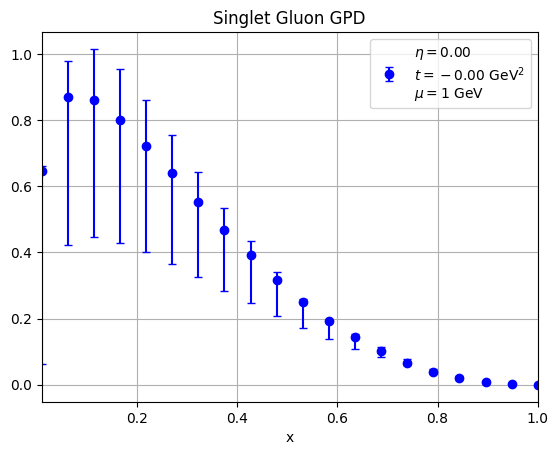

In [ ]:
plot_gluon_gpd(0,-1e-4,1,x_0=1e-2,sampling=False,error_bars=True,n_points=20)

Time for initial sampling: 3.919914 seconds
Time for plot computation: 26.704216 seconds


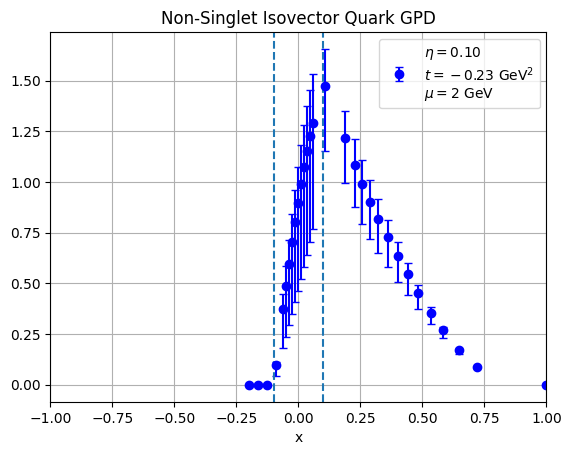

In [ ]:
# Parallelized Data generation
plot_non_singlet_quark_gpd(.1,-0.23,2,3)

Time for initial sampling: 3.449050 seconds
Time for plot computation: 51.526348 seconds


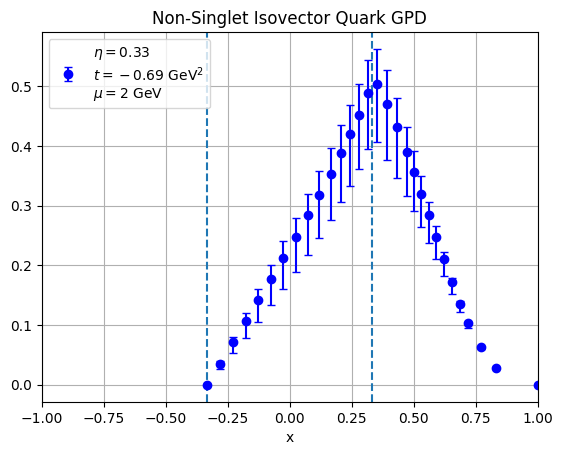

In [ ]:
plot_non_singlet_quark_gpd(1/3,-0.69,2)

Time for initial sampling: 3.809502 seconds
Time for plot computation: 30.157908 seconds


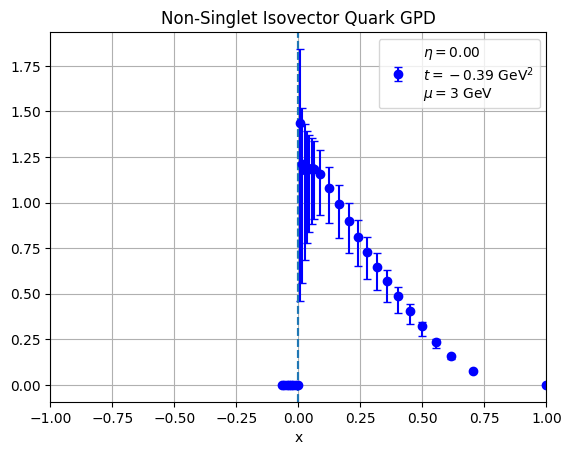

In [ ]:
plot_non_singlet_quark_gpd(0,-0.39,3)

Time for initial sampling: 4.930900 seconds
Time for plot computation: 36.278120 seconds


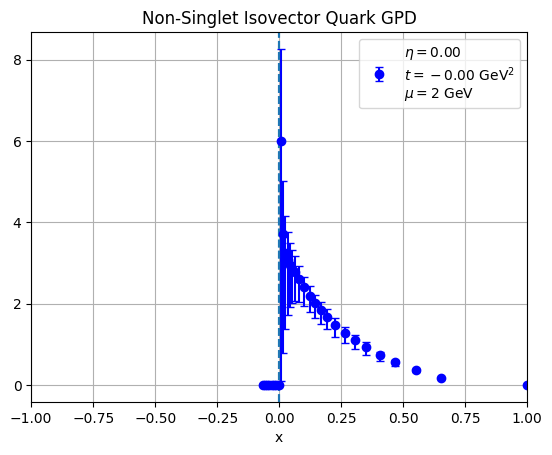

In [ ]:
plot_non_singlet_quark_gpd(0,-1e-6,2)

Time for initial sampling: 91.137086 seconds
Time for plot computation: 176.539518 seconds


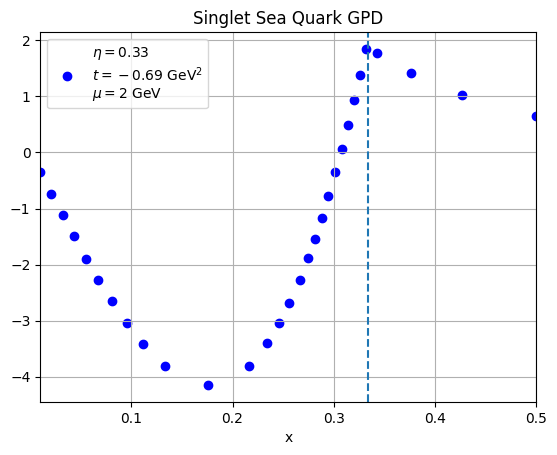

In [21]:
plot_singlet_quark_gpd(1/3,-0.69,2,sampling=True,error_bars=False,n_points=30,x_1=.5)

Time for initial sampling: 152.091074 seconds
Time for plot computation: 354.528282 seconds


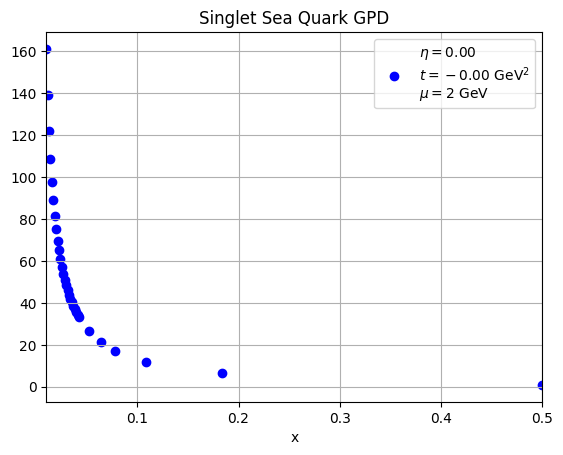

In [ ]:
plot_singlet_quark_gpd(0,-1e-3,2,sampling=True,error_bars=False,n_points=30,x_1=.5)

Time for initial sampling: 47.463630 seconds
Time for plot computation: 113.382664 seconds


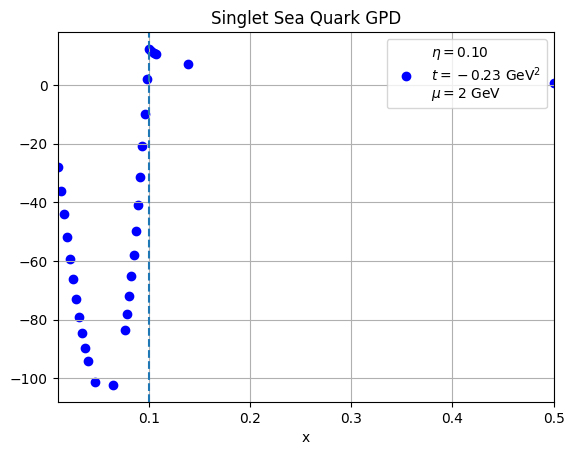

In [ ]:
plot_singlet_quark_gpd(0.1,-0.23,2,sampling=True,error_bars=False,n_points=30,x_1=.5)

Time for initial sampling: 46.541051 seconds
Time for plot computation: 69.514112 seconds


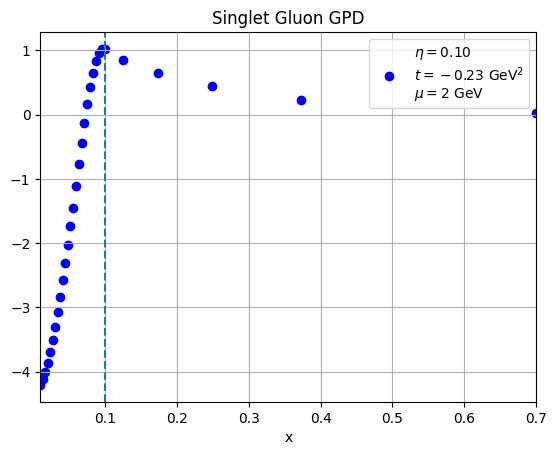

In [ ]:
plot_gluon_gpd(0.1,-0.23,2,sampling=True,error_bars=False,n_points=30,x_1=.7)

Time for initial sampling: 40.984003 seconds
Time for plot computation: 103.650461 seconds


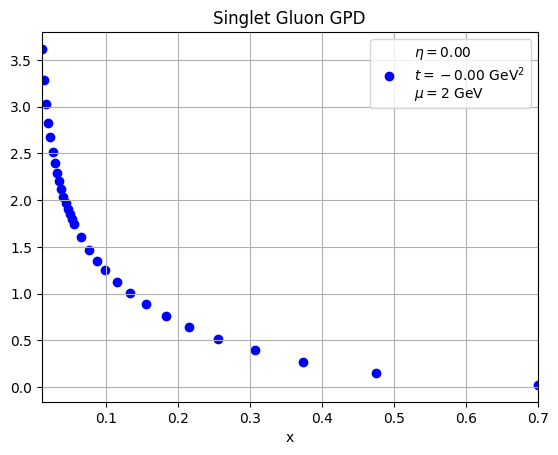

In [ ]:
plot_gluon_gpd(0,-1e-3,2,sampling=True,error_bars=False,n_points=30,x_1=.7)

Time for initial sampling: 22.027001 seconds
Time for plot computation: 49.279190 seconds


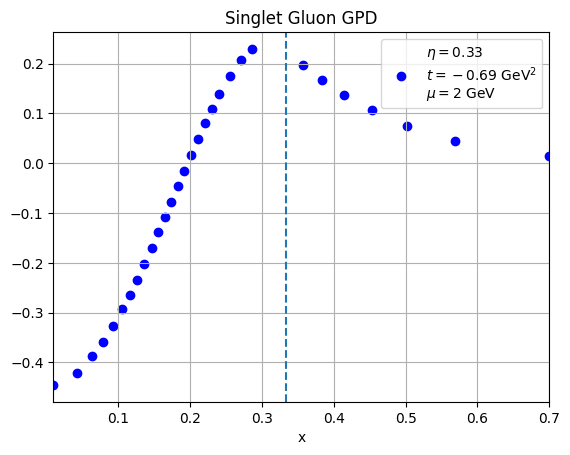

In [ ]:
plot_gluon_gpd(1/3,-0.69,2,sampling=True,error_bars=False,n_points=30,x_1=.7)